In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import dare
from kalman import KalmanFilter
import constants as ct
from parameters import *
from particle1D import Particle

In [1]:
delta_t = 1e-9
control_step = int(32e-9/delta_t)
t = np.arange(0, 10 * (1/100e3), delta_t)
N = t.shape[0]
pressure = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6352e-6 
eta_detection = 0.178
fs = 1/(control_step*delta_t)

gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist,
                                                                      radius, pressure, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)

env = Particle(omega, gamma, coupling, eta_detection=eta_detection, radius = radius)
std_detection = std_detection/env.zp_x

NameError: name 'np' is not defined

In [ ]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])

In [ ]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0],
                        [0, omega/2]])
g_fb = omega
X, L, G = dare(Ad, Bd, cost_states, omega/(g_fb**2))

In [ ]:
x0 = std_detection
P0 = std_detection**2*np.matrix(np.eye(2))
estimation = np.matrix([[x0*np.random.normal()], [x0*np.random.normal()]])
states = np.array([[x0*np.random.normal()], [x0*np.random.normal()]])
new_states = np.zeros((N, 2))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0, :] = estimation.reshape((2))
estimation = estimation.reshape((2, 1))
control = np.array([[0]])
controls = []
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[0,0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((2))
        estimation = estimated_states[i, :].reshape((2, 1))
        control = -G @ estimation
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls.append(float(control))
    states = env.step(states, control=control, delta_t=delta_t)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:04<00:00, 23006.52it/s]


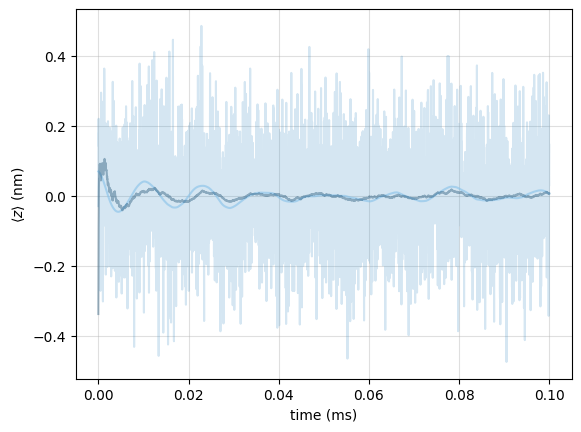

In [34]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_x*1e9*measured_states[::control_step], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_x*1e9*new_states[::control_step,0], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_x*1e9*estimated_states[::control_step,0], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle z \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)